In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['XLA_FLAGS'] ='--xla_gpu_deterministic_ops=true'


#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".25"

import torch
torch.multiprocessing.set_start_method('spawn')

In [4]:
# Add parent folder to path (to run this file from subdirectories)
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)

# add git submodule to path to allow imports to work
submodule_name = 'AlphaTrade'
sys.path.append(os.path.join(parent_folder_path, submodule_name))

print(sys.path)

from gymnax_exchange.jaxob.jorderbook import OrderBook
import gymnax_exchange.jaxob.JaxOrderBookArrays as job

['/data1/sascha/LOBS5/lob', '/data1/sascha/AlphaTrade', '/home/sascha/miniconda3/envs/alphatrade_new/lib/python310.zip', '/home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10', '/home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/lib-dynload', '', '/home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages', '/data1/sascha/LOBS5', '/data1/sascha/LOBS5/AlphaTrade']


In [5]:
# from argparse import Namespace
from glob import glob
import numpy as onp
import pandas as pd
# from functools import partial
# from typing import Union, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# from line_profiler import LineProfiler

import jax
import jax.numpy as jnp
from jax.nn import one_hot
# from jax import random
# from jax.scipy.linalg import block_diag
# from flax import jax_utils
# from flax.training import checkpoints
# import orbax

#from lob.lob_seq_model import BatchLobPredModel
# from lob.train_helpers import create_train_state, eval_step, prep_batch, cross_entropy_loss, compute_accuracy
from s5.ssm import *
# from s5.ssm_init import make_DPLR_HiPPO
# from s5.dataloading import make_data_loader
# from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
# from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER

import preproc
# import inference
from lob import inference_no_errcorr as inference
import validation_helpers as valh
from lob.init_train import init_train_state, load_checkpoint, load_metadata, load_args_from_checkpoint
# import lob.encoding as encoding

# necessary for flax checkpoints to be loaded in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

from functools import partial



2024-07-22 08:53:59.589479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 08:53:59.621285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 08:53:59.630406: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 08:54:02.282687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
#@partial(onp.vectorize, signature="(c),(),()->(c)")
def transform_L2_state_two(
        book: onp.ndarray, 
        price_levels: int,
        tick_size: int = 100,
        #divide_by: int = 1,
    ) -> onp.ndarray:
    """ Transformation for data loading:
        Converts L2 book state from data to price_levels many volume
        series used as ionput to the model. The first element (column) of the
        ionput and output is the change in mid price.
        Converts sizes to negative sizes for ask side (sell orders).
    """
    delta_p_mid, book = book[:1], book[1:]
    book = book.reshape((-1,2))
    mid_price = onp.ceil((book[0, 0] + book[1, 0]) / (2*tick_size)).__mul__(tick_size).astype(int)
    book[:, 0] = (book[:, 0] - mid_price) // tick_size
    # change relative prices to indices
    book[:, 0] = book[:, 0] + price_levels // 2
    # set to out of bounds index, so that we can use -1 to indicate nan
    # out of bounds will be ignored in setting value in jax
    book = onp.where(book < 0, -price_levels-1, book)

    mybook = onp.zeros(price_levels, dtype=onp.int32)
    mybook[book[:, 0]]=book[:, 1]
    
    # set ask volume to negative (sell orders)
    mybook[price_levels // 2:]=mybook[price_levels // 2:] * -1
    mybook = onp.concatenate((
        delta_p_mid.astype(onp.float32),
        mybook.astype(onp.float32) / 1000
    ))

    # return mybook.astype(jonp.float32) #/ divide_by
    return mybook 

# Scratch

In [7]:
x_m=jnp.arange(0,30).reshape((10,3))
print(x_m)
x_b=jnp.arange(30,45).reshape((5,3))
print(x_b)
x_b = jnp.repeat(x_b, x_m.shape[0] // x_b.shape[0], axis=0)
print(x_b)
jnp.concatenate([x_m,x_b],axis=1)

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]
 [21 22 23]
 [24 25 26]
 [27 28 29]]
[[30 31 32]
 [33 34 35]
 [36 37 38]
 [39 40 41]
 [42 43 44]]
[[30 31 32]
 [30 31 32]
 [33 34 35]
 [33 34 35]
 [36 37 38]
 [36 37 38]
 [39 40 41]
 [39 40 41]
 [42 43 44]
 [42 43 44]]


Array([[ 0,  1,  2, 30, 31, 32],
       [ 3,  4,  5, 30, 31, 32],
       [ 6,  7,  8, 33, 34, 35],
       [ 9, 10, 11, 33, 34, 35],
       [12, 13, 14, 36, 37, 38],
       [15, 16, 17, 36, 37, 38],
       [18, 19, 20, 39, 40, 41],
       [21, 22, 23, 39, 40, 41],
       [24, 25, 26, 42, 43, 44],
       [27, 28, 29, 42, 43, 44]], dtype=int32)

# Model RNN Test

In [8]:
from lob import lob_seq_model
from s5.ssm import init_S5SSM
import argparse
from lob.encoding import Vocab
from lob.init_train import init_train_state, load_checkpoint, save_checkpoint, deduplicate_trainstate
from lob.dataloading import create_lobster_prediction_dataset, create_lobster_train_loader#, Datasets
from lob.lobster_dataloader import LOBSTER_Dataset
from flax import jax_utils

from lob.train_helpers import cross_entropy_loss
from s5.train_helpers import cross_entropy_loss as cross_entropy_loss_original

jnp.set_printoptions(edgeitems=5,linewidth=250)

In [9]:
#lob_seq_model.BatchPaddedLobPredModel()

In [31]:
class Args(argparse.Namespace):
  USE_WANDB=False
  wandb_project="LOBS5"
  wandb_entity="peer-nagy"
  dir_name='/data1/sascha/data/data/GOOG'
  dataset='lobster-prediction'
  masking='none'
  use_book_data=True
  merging='padded'
  use_simple_book=False
  book_transform=True
  book_depth=500
  restore=None
  restore_step=None
  msg_seq_len=500
  n_data_workers=0
  n_message_layers=3
  n_book_pre_layers=1
  n_book_post_layers=1
  n_layers=6
  d_model=64
  ssm_size_base=32
  blocks=8
  C_init="trunc_standard_normal"
  discretization="zoh"
  mode="pool"
  activation_fn="half_glu1"
  conj_sym=False
  clip_eigs=True
  bidirectional=False
  dt_min=0.001
  dt_max=0.1
  prenorm=True
  batchnorm=True
  bn_momentum=0.95
  bsz=2
  num_devices=1
  epochs=100
  early_stop_patience=1000
  ssm_lr_base=1e-3
  lr_factor=1
  dt_global=False
  lr_min=0
  cosine_anneal=True
  warmup_end=1
  lr_patience=1000000
  reduce_factor=1.0
  p_dropout=0.0
  weight_decay=0.05
  opt_config="standard"
  jax_seed=1919

args=Args()
  

In [32]:
ssm_size = args.ssm_size_base
ssm_lr = args.ssm_lr_base
block_size = int(ssm_size / args.blocks)
lr = args.lr_factor * ssm_lr

key = jax.random.PRNGKey(args.jax_seed)
init_rng, train_rng = jax.random.split(key, num=2)
ds = 'lobster-prediction'
#create_dataset_fn =  Datasets[ds]

# Create dataset...
init_rng, key = jax.random.split(init_rng, num=2)
if args.masking == 'causal':
    mask_fn = LOBSTER_Dataset.causal_mask
elif args.masking == 'random':
    mask_fn = LOBSTER_Dataset.random_mask
elif args.masking == 'last_pos':
    mask_fn = LOBSTER_Dataset.last_pos_mask
elif args.masking == 'none':
    mask_fn = LOBSTER_Dataset.no_mask
else:
    ValueError('Issue with mask function: logic for '+args.masking+' not implemented.')

(lobster_dataset, trainloader, valloader, testloader, aux_dataloaders, 
    n_classes, seq_len, in_dim, book_seq_len, book_dim, train_size) = \
    create_lobster_prediction_dataset(
        args.dir_name,
        seed=args.jax_seed,
        mask_fn=mask_fn,
        msg_seq_len=args.msg_seq_len,
        bsz=args.bsz,
        use_book_data=args.use_book_data,
        use_simple_book=args.use_simple_book,
        book_transform=args.book_transform,
        n_data_workers=args.n_data_workers,
    )


[*] Generating LOBSTER Prediction Dataset from /data1/sascha/data/data/GOOG
23
FILEs loaded
Using mask function: <function LOBSTER_Dataset.no_mask at 0x7f0f3007e680>


In [34]:
rng=jax.random.PRNGKey(args.jax_seed)

In [35]:
state, model_cls = init_train_state(
        args,
        n_classes=n_classes,
        seq_len=seq_len,
        book_dim=book_dim,
        book_seq_len=book_seq_len,
        print_shapes=True
    )


state = jax_utils.unreplicate(state)


Lambda.shape=(32,)
V.shape=(32, 32)
Vinv.shape=(32, 32)
book_seq_len 500
book_dim 501
Dummy input shapes (msg,book) ((Array(2, dtype=int32, weak_type=True), Array(11000, dtype=int32, weak_type=True)), 
 (Array(2, dtype=int32, weak_type=True), Array(11000, dtype=int32, weak_type=True), Array(501, dtype=int32, weak_type=True)))
(12012, 64)
configuring standard optimization setup
[*] Trainable Parameters: 2033561
(12012, 64)
(1, 12012, 64)


In [36]:
state.params['message_encoder']['layers_0']['out2']['kernel'].shape


(64, 64)

In [37]:
rng, array_rng = jax.random.split(rng)
test_input = (jnp.ones((2, 11000, ),dtype=jnp.int32) , jnp.ones((2, 500, 501),dtype=jnp.int32) )
int_ts = (jnp.ones((2, 11000, )),jnp.ones((2, 500, )) )
hiddens=model_cls().initialize_carry(batch_size=2, hidden_size=32,
                         n_message_layers=args.n_message_layers,
                         n_book_pre_layers=args.n_book_pre_layers ,
                         n_book_post_layers=args.n_book_post_layers,
                         n_fused_layers=args.n_layers,)
dones=(jnp.zeros((2,11000,),dtype=bool),)*3


P=32
H=32

B_bar_dummy=jax.random.uniform(array_rng,(P,H))
Lambda_dummy=jax.random.uniform(array_rng,(P,))
seq_in_enc=jax.random.uniform(array_rng,(5, P))
hidden_test=jnp.zeros((1,H,))


In [38]:
print(jax.tree.structure(hiddens))
print(jax.tree.structure(test_input))
print(jax.tree_util.tree_map(jnp.shape,test_input))

PyTreeDef(([*, *, *], ([*], [*]), [*, *, *, *, *, *]))
PyTreeDef((*, *))
((2, 11000), (2, 500, 501))


In [18]:
test_inputs=jax.tree_util.tree_map(lambda x: jnp.split(x,4,axis=1),test_input)
print(jax.tree_util.tree_map(jnp.shape,test_inputs))
def f(num, arrays):
    jax.debug.print("{}",jax.tree_util.tree_map(jnp.shape,arrays))
    return 0,0


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱  1 test_inputs=jax.tree_util.tree_map(lambda x: jnp.split(x,z_,axis=1),test_input)             │
│    2 print(jax.tree_util.tree_map(jnp.shape,test_inputs))                                        │
│    3 def f(num, arrays):                                                                         │
│    4 │   jax.debug.print("{}",jax.tree_util.tree_map(jnp.shape,arrays))                          │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/jax/_src/tree_util.py:3 │
│ 21 in tree_map                                                                                   │
│                                                                                                  │
│    318   """                                                                                     │
│    319   leaves, treedef = tree_flatten(tree, is_leaf)                                           │
│    320   all_leaves = [leaves] + [treedef.flatten_up_to(r) for r in rest]                        │
│ ❱  321   return treedef.unflatten(f(*xs) for xs in zip(*all_leaves))                             │
│    322                                                                                           │
│    323                                                                                           │
│    324 def build_tree(treedef: PyTreeDef, xs: Any) -> Any:                                       │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/jax/_src/tree_util.py:3 │
│ 21 in <genexpr>                                                                                  │
│                                                                                                  │
│    318   """                                                                                     │
│    319   leaves, treedef = tree_flatten(tree, is_leaf)                                           │
│    320   all_leaves = [leaves] + [treedef.flatten_up_to(r) for r in rest]                        │
│ ❱  321   return treedef.unflatten(f(*xs) for xs in zip(*all_leaves))                             │
│    322                                                                                           │
│    323                                                                                           │
│    324 def build_tree(treedef: PyTreeDef, xs: Any) -> Any:                                       │
│                                                                                                  │
│ in <lambda>:1                                                                                    │
│                                                                                                  │
│ ❱  1 test_inputs=jax.tree_util.tree_map(lambda x: jnp.split(x,z_,axis=1),test_input)             │
│    2 print(jax.tree_util.tree_map(jnp.shape,test_inputs))                                        │
│    3 def f(num, arrays):                                                                         │
│    4 │   jax.debug.print("{}",jax.tree_util.tree_map(jnp.shape,arrays))                          │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/jax/_src/numpy/lax_nump │
│ y.py:1504 in split                                                                               │
│                                                            

In [39]:
rng, drop_rng = jax.random.split(rng)


In [43]:
from lob.train_helpers import repeat_book

test_input=repeat_book(*test_input)
a,b=test_input
print(a.shape,b.shape)


(2, 11000) (2, 11000, 501)


In [41]:
@partial(np.vectorize, signature="(c),()->()")
def cross_entropy_loss(logits, label):
    return -np.sum(logits[label])

In [44]:


logits_full,new_vars=state.apply_fn(
                {"params": state.params},
                *test_input,
                *int_ts,
                rngs={"dropout": drop_rng},
                mutable=["intermediates","batch_stats"],
                method='__call_ar__'
            )

print(logits_full.shape)

(2, 11000, 12012)


In [60]:
labels=jnp.ones_like(test_input[0])
print(labels.squeeze().shape)

#batches=2

#ce_0=cross_entropy_loss_original(logits_full, labels)
ce=cross_entropy_loss(logits_full, labels.squeeze())
ce_0=-logits_full[0][0][labels[0][0]]

loss = np.mean(ce)
print('cross entropy before vect for single elem',ce_0)
print('cross entropy after vect \n',ce)
print(labels[0][0])
print(logits_full[0][0])

print(np.mean(ce))

(2, 11000)
cross entropy before vect for single elem 424.80084
cross entropy after vect 
 [[424.80084   89.7575    72.50923   67.78286   81.18617  ...   9.8248     9.824799   9.824795   9.824792   9.824766]
 [424.80084   89.7575    72.50923   67.78286   81.18617  ...   9.8248     9.824799   9.824795   9.824792   9.824766]]
1
[-703.4432  -424.80084 -410.25446 -373.5528  -461.80652 ... -537.5015  -417.6493  -409.9294  -477.62863 -380.6071 ]
11.332051


In [ ]:
Lambda_elements = Lambda_dummy  * jnp.ones((seq_in_enc.shape[0],
                                            Lambda_dummy.shape[0]))
Bu_elements = jax.vmap(lambda u: B_bar_dummy @ u)(seq_in_enc)

    #jax.debug.print("call ssm Bu_elems : {}",Bu_elements)
    #jax.debug.print("call ssm Lambda_elems : {}",Bu_elements)

_, xs_1 = jax.lax.associative_scan(binary_operator, (Lambda_elements, Bu_elements))
_,xs_3=jax.lax.associative_scan(binary_operator, (Lambda_elements, Bu_elements))

Lambda_elements_2 = np.concatenate([
    np.ones((1, Lambda_dummy.shape[0])),
    Lambda_elements,
])
Bu_elements_2 = np.concatenate([
    hidden_test,
    Bu_elements,
])

_,xs_2=jax.lax.associative_scan(binary_operator, (Lambda_elements_2, Bu_elements_2))

In [ ]:
print(Bu_elements_2[1:]-Bu_elements)
print(xs_1-xs_2[1:])
print(xs_1-xs_3)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0

In [21]:

hiddens_roll=hiddens
for i in range(4):
    (hiddens_roll,logits_rnn_sequence),new_vars=state.apply_fn(
                {"params": state.params},
                hiddens_roll,
                test_inputs[0][i],
                test_inputs[1][i],
                donessss[0][i],
                donessss[1][i],
                donessss[2][i],
                tss[0][i],
                tss[1][i],
                rngs={"dropout": drop_rng},
                mutable=["intermediates","batch_stats"],
                method='__call_rnn__'
            )


(hiddens,logits_rnn_full),new_vars=state.apply_fn(
                {"params": state.params},
                hiddens,
                *test_input,
                *dones,
                *int_ts,
                rngs={"dropout": drop_rng},
                mutable=["intermediates","batch_stats"],
                method='__call_rnn__'
            )


logits_full,new_vars=state.apply_fn(
                {"params": state.params},
                *test_input,
                *int_ts,
                rngs={"dropout": drop_rng},
                mutable=["intermediates","batch_stats"],
                method='__call__'
            )


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 hiddens_roll=hiddens                                                                        │
│    2 for i in range(4):                                                                          │
│ ❱  3 │   (hiddens_roll,logits_rnn_sequence),new_vars=state.apply_fn(                             │
│    4 │   │   │   │   {"params": state.params},                                                   │
│    5 │   │   │   │   hiddens_roll,                                                               │
│    6 │   │   │   │   test_inputs[0][i],                                                          │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/jax/_src/traceback_util │
│ .py:179 in reraise_with_filtered_traceback                                                       │
│                                                                                                  │
│   176   def reraise_with_filtered_traceback(*args, **kwargs):                                    │
│   177 │   __tracebackhide__ = True                                                               │
│   178 │   try:                                                                                   │
│ ❱ 179 │     return fun(*args, **kwargs)                                                          │
│   180 │   except Exception as e:                                                                 │
│   181 │     mode = _filtering_mode()                                                             │
│   182 │     if _is_under_reraiser(e) or mode == "off":                                           │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/flax/linen/module.py:22 │
│ 52 in apply                                                                                      │
│                                                                                                  │
│   2249 │   elif method is None:                                                                  │
│   2250 │     method = self.__call__                                                              │
│   2251 │   method = _get_unbound_fn(method)                                                      │
│ ❱ 2252 │   return apply(                                                                         │
│   2253 │     method,                                                                             │
│   2254 │     self,                                                                               │
│   2255 │     mutable=mutable,                                                                    │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/flax/core/scope.py:1101 │
│ in wrapper                                                                                       │
│                                                                                                  │
│   1098 │   with bind(                                                                            │
│   1099 │     variables, rngs=rngs, mutable=mutable, flags=flags                                  │
│   1100 │   ).temporary() as root:                                                                │
│ ❱ 1101 │     y = fn(root, *args, **kwargs)                                                       │
│   1102 │   if mutable is not False:                        

In [17]:
print(jnp.sum(logits_rnn_full[0]))
logits_rnn_full[0]


-118516.75


Array([-10.424554,  -9.156684, -11.390747, -12.268012,  -8.928606, ..., -11.006114,  -9.965927,  -9.698513,  -9.778618,  -9.290848], dtype=float32)

In [19]:
print(jnp.sum(logits_rnn_sequence[0]))
logits_rnn_sequence[0]

-118344.85


Array([-10.58164 ,  -8.867035, -11.37709 , -12.295605,  -9.244386, ..., -11.014713, -10.306179,  -9.506303,  -9.73818 ,  -9.142728], dtype=float32)

In [20]:
print(jnp.sum(logits_full[0]))
logits_full[0]

-118514.445


Array([-10.424288,  -9.158066, -11.3899  , -12.267988,  -8.928334, ..., -11.003961,  -9.966434,  -9.698198,  -9.77877 ,  -9.290585], dtype=float32)

In [21]:
jnp.average(jnp.abs(logits_rnn_sequence[0]-logits_rnn_full[0])/logits_rnn_sequence[0])


Array(-0.02040548, dtype=float32)

In [22]:
jnp.average(jnp.abs(logits_rnn_full[0]-logits_full[0])/logits_rnn_full[0])


Array(-4.9103073e-05, dtype=float32)

In [23]:
jnp.average(jnp.abs(logits_rnn_sequence[0]-logits_full[0])/logits_rnn_sequence[0])

Array(-0.02041057, dtype=float32)

## Model

In [13]:
n_messages = 500
v = Vocab()
n_classes = len(v)
seq_len = n_messages * Message_Tokenizer.MSG_LEN
book_dim = 501 #b_enc.shape[1]
book_seq_len = n_messages

rng = jax.random.key(42)
rng, rng_ = jax.random.split(rng)

Vocab.HIDDEN_TOK

1

In [49]:
a=jnp.array([[[1,2,3],
            [1,2,3],
            [1,2,3],
            [1,2,3],
            [1,2,3],
            [1,2,3],
            [1,2,3],
            [1,2,3],
            [1,2,3],
            [1,2,3]],
           [[4,5,6],
            [4,5,6],
            [4,5,6],
            [4,5,6],
            [4,5,6],
            [4,5,6],
            [4,5,6],
            [4,5,6],
            [4,5,6],
            [4,5,6]]])
b=jnp.array([[1,1,1,1,1,1,1,1],
           [4,4,4,4,4,4,4,4]])

xs=(a,b)
print(b.shape)
xs=jax.tree_util.tree_map(lambda x: np.swapaxes(x,0,1),xs)


(2, 8)


(Array([[[1, 2, 3],
         [4, 5, 6]],
 
        [[1, 2, 3],
         [4, 5, 6]],
 
        [[1, 2, 3],
         [4, 5, 6]],
 
        [[1, 2, 3],
         [4, 5, 6]],
 
        [[1, 2, 3],
         [4, 5, 6]],
 
        [[1, 2, 3],
         [4, 5, 6]],
 
        [[1, 2, 3],
         [4, 5, 6]],
 
        [[1, 2, 3],
         [4, 5, 6]],
 
        [[1, 2, 3],
         [4, 5, 6]],
 
        [[1, 2, 3],
         [4, 5, 6]]], dtype=int32),
 Array([[1, 4],
        [1, 4],
        [1, 4],
        [1, 4],
        [1, 4],
        [1, 4],
        [1, 4],
        [1, 4]], dtype=int32))

In [8]:
stock = 'TSLA' # 'GOOG', 'INTC' ,'TSLA'

In [9]:
if stock == 'GOOG':
    # ckpt_path = '../checkpoints/treasured-leaf-149_84yhvzjt/' # 0.5 y GOOG, (full model)
    ckpt_path = '../checkpoints/denim-elevator-754_czg1ss71/' # large model
elif stock == 'INTC':
    ckpt_path = '../checkpoints/pleasant-cherry-152_i6h5n74c/' # 0.5 y INTC, (full model)
elif stock == 'TSLA':
    ckpt_path = '../checkpoints/rural-serenity-60_uxc2c11x//' # Dummy model trained on just 5 days... for debugging. 

In [10]:
ckpt_path

'../checkpoints/denim-elevator-754_czg1ss71/'

In [11]:
# args = load_args_from_checkpoint(ckpt_path)
args = load_metadata(ckpt_path)
args

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # args = load_args_from_checkpoint(ckpt_path)                                                │
│ ❱ 2 args = load_metadata(ckpt_path)                                                              │
│   3 args                                                                                         │
│   4                                                                                              │
│                                                                                                  │
│ /data1/sascha/LOBS5/lob/init_train.py:110 in load_metadata                                       │
│                                                                                                  │
│   107 │                                                                                          │
│   108 │   json_path = path + '/metadata/metadata'                                                │
│   109 │   # load json path to dict                                                               │
│ ❱ 110 │   with open(json_path, 'r') as f:                                                        │
│   111 │   │   metadata = json.load(f)                                                            │
│   112 │   return Namespace(**metadata)                                                           │
│   113                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileNotFoundError: [Errno 2] No such file or directory: 
'../checkpoints/denim-elevator-754_czg1ss71//metadata/metadata'

In [15]:
# scale down to single GPU, single sample inference
args.bsz = 1 #1, 10
args.num_devices = 1

batchnorm = args.batchnorm

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # scale down to single GPU, single sample inference                                          │
│ ❱ 2 args.bsz = 1 #1, 10                                                                          │
│   3 args.num_devices = 1                                                                         │
│   4                                                                                              │
│   5 batchnorm = args.batchnorm                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'args' is not defined

In [5]:
new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=seq_len,
    book_dim=book_dim,
    book_seq_len=book_seq_len,
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 new_train_state, model_cls = init_train_state(                                               │
│ ❱ 2 │   args,                                                                                    │
│   3 │   n_classes=n_classes,                                                                     │
│   4 │   seq_len=seq_len,                                                                         │
│   5 │   book_dim=book_dim,                                                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'args' is not defined

In [13]:
# load train state from disk
args = load_metadata(ckpt_path)



new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=seq_len,
    book_dim=book_dim,
    book_seq_len=book_seq_len,
)

ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    train=False,
)
state = ckpt['model']

configuring standard optimization setup
[*] Trainable Parameters: 35776312


In [14]:
#ckpt['model'].params['book_out_proj']['kernel'].shape#.keys()

In [15]:
# # deduplicate params (they get saved per gpu in training)
# state = par_state.replace(
#     params=jax.tree_map(lambda x: x[0], par_state.params),
#     batch_stats=jax.tree_map(lambda x: x[0], par_state.batch_stats),
# )

In [18]:
model = model_cls(training=False, step_rescale=1.0)
model()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 model = model_cls(training=False, step_rescale=1.0)                                          │
│ ❱ 2 model()                                                                                      │
│   3                                                                                              │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/flax/linen/transforms.p │
│ y:378 in wrapped_fn                                                                              │
│                                                                                                  │
│    375 │     # here we apply the given lifting transform to the scope-ingesting fn               │
│    376 │     trafo_fn = transform(core_fn, *trafo_args, **trafo_kwargs)                          │
│    377 │     module_scopes, args, kwargs = get_module_scopes(self, args, kwargs)                 │
│ ❱  378 │     ret = trafo_fn(module_scopes, *args, **kwargs)                                      │
│    379 │     return ret                                                                          │
│    380 │                                                                                         │
│    381 │   return wrapped_fn                                                                     │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/flax/core/lift.py:325   │
│ in wrapper                                                                                       │
│                                                                                                  │
│    322 │   │   │   **kwargs,                                                                     │
│    323 │   │   )                                                                                 │
│    324 │     else:                                                                               │
│ ❱  325 │   │   y, out_variable_groups_xs_t = fn(                                                 │
│    326 │   │   │   scope_fn, repack_fn, variable_groups_xs_t, rng_groups_xs_t, *args             │
│    327 │   │   )                                                                                 │
│    328 │   finally:                                                                              │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/flax/core/lift.py:801   │
│ in inner                                                                                         │
│                                                                                                  │
│    798 │     return ()                                                                           │
│    799 │                                                                                         │
│    800 │   # split rngs                                                                          │
│ ❱  801 │   axis_sizes = jax.tree_util.tree_map(                                                  │
│    802 │     find_axis_size, (variable_in_axes, in_axes), (variable_groups, args)                │
│    803 │   )                                                                                     │
│    804 │   axis_sizes = set(jax.tree_util.tree_leaves(axis_sizes))                               │
│                                                            

# Forecasting

In [79]:
import lob.evaluation as eval
from preproc import transform_L2_state

In [33]:
n_gen_msgs = 100  #500 # how many messages to generate into the future
n_messages = 500
n_eval_messages = 100  # how many to load from dataset 
eval_seq_len = (n_eval_messages-1) * Message_Tokenizer.MSG_LEN

data_levels = 10
# TODO: deprecated - remove from functions
sim_book_levels = 20 # 10  # order book simulator levels
sim_queue_len = 100  # per price in sim, how many orders in queue

n_vol_series = 500  # how many book volume series model uses as input

v = Vocab()
n_classes = len(v)
book_dim = 501 #b_enc.shape[1]
eval_book_seq_len = eval_seq_len

rng = jax.random.key(42)
rng, rng_ = jax.random.split(rng)

In [29]:
stock='TSLA'

In [30]:
# entire test set after training data

if stock == 'GOOG':
    data_dir = '/nfs/home/peern/LOBS5/data/test_set/GOOG/'
elif stock == 'INTC':
    data_dir = '/nfs/home/peern/LOBS5/data/test_set/INTC/'
elif stock == 'TSLA':
    ckpt_path = '../checkpoints/rural-serenity-60_uxc2c11x//' # Dummy model trained on just 5 days... for debugging. 



In [1]:
# load train state from disk
args = load_metadata(ckpt_path)
ds = inference.get_dataset(args.dir_name, n_messages, n_eval_messages)

new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=eval_seq_len,
    book_dim=book_dim,
    book_seq_len=eval_book_seq_len,
)

ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    train=False,
)
state = ckpt['model']

NameError: name 'load_metadata' is not defined

In [18]:
ds.message_files

['/data1/sascha/data/lobster_proc/TSLA_2015-01-02_34200000_57600000_message_10_proc.npy',
 '/data1/sascha/data/lobster_proc/TSLA_2015-01-05_34200000_57600000_message_10_proc.npy',
 '/data1/sascha/data/lobster_proc/TSLA_2015-01-06_34200000_57600000_message_10_proc.npy',
 '/data1/sascha/data/lobster_proc/TSLA_2015-01-07_34200000_57600000_message_10_proc.npy',
 '/data1/sascha/data/lobster_proc/TSLA_2015-01-08_34200000_57600000_message_10_proc.npy']

In [18]:
import chex
chex.clear_trace_counter()

In [19]:
import logging
# logging.basicConfig(filename='ar_debug.log', level=logging.DEBUG)
fhandler = logging.FileHandler(filename='ar_debug.log', mode='w')
logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)
# logger.setLevel(logging.WARNING)

In [21]:
rng = jax.random.key(42)
rng, rng_ = jax.random.split(rng)

In [23]:
sample_top_n = 50
tick_size = 100

In [37]:
model = model_cls(training=False, step_rescale=1.0)


In [39]:
i = 200
l2_state_n = 20
m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[int(i)]

b_seq = jnp.array(transform_L2_state(b_seq_pv, n_vol_series, 100))
m_seq_raw_inp = msg_seq_raw[: n_messages]

# with jax.disable_jit():

# initialise simulator
sim_init, sim_state_init = inference.get_sim(
    book_l2_init,  # book state before any messages
    m_seq_raw_inp, # messages to replay to init sim
)
# # book state after initialisation (replayed messages)
# l2_book_state_init = sim_init.get_L2_state(sim_state_init, l2_state_n)

m_seq, b_seq, msgs_decoded, l2_book_states, num_errors = inference.generate(
    sim_init,
    state,
    model,
    args.batchnorm,
    v.ENCODING,
    sample_top_n,
    tick_size,
    m_seq[:11000],
    b_seq[:500],
    n_gen_msgs,
    sim_state_init,
    rng,
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:18                                                                                   │
│                                                                                                  │
│   15 # # book state after initialisation (replayed messages)                                     │
│   16 # l2_book_state_init = sim_init.get_L2_state(sim_state_init, l2_state_n)                    │
│   17                                                                                             │
│ ❱ 18 m_seq, b_seq, msgs_decoded, l2_book_states, num_errors = inference.generate(                │
│   19 │   sim_init,                                                                               │
│   20 │   state,                                                                                  │
│   21 │   model,                                                                                  │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/jax/_src/traceback_util │
│ .py:179 in reraise_with_filtered_traceback                                                       │
│                                                                                                  │
│   176   def reraise_with_filtered_traceback(*args, **kwargs):                                    │
│   177 │   __tracebackhide__ = True                                                               │
│   178 │   try:                                                                                   │
│ ❱ 179 │     return fun(*args, **kwargs)                                                          │
│   180 │   except Exception as e:                                                                 │
│   181 │     mode = _filtering_mode()                                                             │
│   182 │     if _is_under_reraiser(e) or mode == "off":                                           │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/jax/_src/pjit.py:305 in │
│ cache_miss                                                                                       │
│                                                                                                  │
│    302                                                                                           │
│    303   @api_boundary                                                                           │
│    304   def cache_miss(*args, **kwargs):                                                        │
│ ❱  305 │   outs, out_flat, out_tree, args_flat, jaxpr, attrs_tracked = _python_pjit_helper(      │
│    306 │   │   jit_info, *args, **kwargs)                                                        │
│    307 │   executable = _read_most_recent_pjit_call_executable(jaxpr)                            │
│    308 │   maybe_fastpath_data = _get_fastpath_data(                                             │
│                                                                                                  │
│ /home/sascha/miniconda3/envs/alphatrade_new/lib/python3.10/site-packages/jax/_src/pjit.py:172 in │
│ _python_pjit_helper                                                                              │
│                                                                                                  │
│    169                                                                                           │
│    170 def _python_pjit_helper(jit_info, *args, **kwargs):                                       │
│    171   (args_flat, _, params, _, out_tree, _, arg_names,                                       │
│ ❱  172    attrs_tracked) = _infer_params(jit_info, args, kw

int

In [26]:
l2_book_states[:2]

Array([[903800,      8, 903600,    156, 903900,    458, 903500,     51,
        904000,    500, 903400,    150, 904100,    312, 903300,    112,
        904200,    445, 903200,    200, 904300,    250, 903100,    604,
        904400,    412, 903000,    100, 904500,    250, 902900,    355,
        904600,    400, 902800,    166, 904700,    753, 902700,     55,
        904800,    355, 902600,    100, 904900,    603,     -1,      0,
        905000,    255,     -1,      0,     -1,      0,     -1,      0,
            -1,      0,     -1,      0,     -1,      0,     -1,      0,
            -1,      0,     -1,      0,     -1,      0,     -1,      0,
            -1,      0,     -1,      0,     -1,      0,     -1,      0],
       [903800,      8, 903600,    156, 903900,    458, 903500,     51,
        904000,    700, 903400,    150, 904100,    312, 903300,    112,
        904200,    445, 903200,    200, 904300,    250, 903100,    604,
        904400,    412, 903000,    100, 904500,    250, 902900,

In [22]:
l2_book_states.shape

(100, 80)

In [65]:
book_changed = (l2_book_states[1:] != l2_book_states[:-1]).any(axis=1)
book_changed

Array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True],      dtype=bool)

In [66]:
from lob import encoding

for m, b, bc in zip(msgs_decoded[1:], l2_book_states[1:], book_changed):
    print(f'{encoding.repr_raw_msg(m)}\n book: {b.reshape((-1,4))} \n book changed: {bc} \n\n')

OID:	99
event_type:	1
direction:	0
price_abs:	904000
price:	3
size:	200
delta_t_s:	0
delta_t_ns:	66239
time_s:	34572
time_ns:	490378027
p_ref:	-9999
size_ref:	-9999
time_s_ref:	-9999
time_ns_ref:	-9999

 book: [[903800      8 903600    156]
 [903900    458 903500     51]
 [904000    700 903400    150]
 [904100    312 903300    112]
 [904200    445 903200    200]
 [904300    250 903100    604]
 [904400    412 903000    100]
 [904500    250 902900    355]
 [904600    400 902800    166]
 [904700    753 902700     55]
 [904800    355 902600    100]
 [904900    603     -1      0]
 [905000    255     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]] 
 book changed: True 


OID:	52902602
event_type:	3
direction:	0
price_abs:	904000
price:	3
size:	66
delta_t_s:	0
delta_t_ns:	22610
time_s:	34572
time_ns:	490400637
p_re

In [50]:
# TODO: inspect instances when state doesn't change and debug
#       plot curves when errors occur (when does the book not change?)

In [61]:
num_errors

Array(1, dtype=int32)

In [ ]:
# check to reduce imports to reduce load times

In [103]:
l2_book_states.shape

(100, 80)

In [20]:
m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[[1,2,3,4]]
m_seq = jnp.array(m_seq)
b_seq_pv = jnp.array(b_seq_pv)
msg_seq_raw = jnp.array(msg_seq_raw)
book_l2_init = jnp.array(book_l2_init)

In [22]:
msg_seq_raw

Array([[[ 27209518,         3,         0, ...,        50,     34200,
         881688892],
        [ 27209430,         3,         0, ...,        14,     34200,
         881604196],
        [ 27209370,         3,         0, ...,       100,     34200,
         881507263],
        ...,
        [ 27309306,         1,         1, ...,     -9999,     -9999,
             -9999],
        [ 27309330,         1,         1, ...,     -9999,     -9999,
             -9999],
        [ 27301706,         3,         1, ...,        22,     34201,
          34686092]],

       [[ 27307842,         3,         1, ...,        41,     34201,
          43348242],
        [ 27311462,         1,         1, ...,     -9999,     -9999,
             -9999],
        [ 27309306,         3,         1, ...,        20,     34201,
          46619187],
        ...,
        [ 27643074,         3,         0, ...,       100,     34201,
         833102282],
        [ 27643094,         1,         1, ...,     -9999,     -9999,
   

In [136]:
msg_seq_raw.shape

(4, 600, 14)

In [127]:
n_messages

500

In [128]:
msg_seq_raw.shape

(600, 14)

In [129]:
msg_seq_raw[: n_messages].shape

(500, 14)

In [131]:
seq_len

11000

In [27]:
n_gen_msgs = 200

In [31]:
n_samples = 1 #160
batch_size = 1 #16

# m_seq_gen, b_seq_gen, msgs_decoded, l2_book_states, num_errors = inference.sample_new(
# saves data to disk
inference.sample_new(
    n_samples,
    batch_size,
    ds,
    rng,
    seq_len,
    n_messages,
    n_gen_msgs,
    state,
    model,
    batchnorm,
    v.ENCODING,
    stock,
    save_folder='/nfs/home/peern/LOBS5/data_saved/GOOG_tmp/',
)

  0%|          | 0/1 [00:00<?, ?it/s]

BATCH [19684]


100%|██████████| 1/1 [00:44<00:00, 44.12s/it]

num_errors [0]


In [80]:
l2_book_states.shape

(10, 100, 80)

In [ ]:
# TODO: check "error rate" / sequence divergence for general case 
#       (when book states do change)

#       generate sequences to eval with new benchmark

In [32]:
results = inference.sample_messages(
    n_samples = 4, # 500
    num_repeats = 1,
    ds = ds,
    rng = rng,
    seq_len = seq_len,
    n_msgs = n_messages,
    n_gen_msgs = n_gen_msgs,
    train_state = state,
    model = model,
    batchnorm = batchnorm,
    encoder = v.ENCODING,
    n_vol_series = n_vol_series,
    sim_book_levels = sim_book_levels,
    sim_queue_len = sim_queue_len,
    data_levels = data_levels,
    # save_folder='../data/results/{stock}/inference/'
    save_folder='../tmp_test/'
)

  0%|          | 0/4 [00:00<?, ?it/s]

Skipping existing sample 4538...
Skipping existing sample 25034...
Skipping existing sample 39921...
Processing sample 38477...
ITERATION 0
original / ref.d order not found


100%|██████████| 4/4 [00:51<00:00, 12.79s/it]


In [22]:
# load all tmp files saved during inference and combine to single dict

import pickle

# tmp_files = glob('./tmp_small/*')
# tmp_files = glob('./tmp/*')

tmp_files = glob(f'../data/results/{stock}/inference/*')

assert len(tmp_files) > 0, 'no tmp files found'

all_metrics = []
for file in tmp_files:
    with open(file, 'rb') as f:
        sequence_metrics = pickle.load(f)
        all_metrics.append(sequence_metrics)
# combine metrics into single dict
results = {
    metric: jnp.array([d[metric] for d in all_metrics])
    for metric in all_metrics[0].keys()
}

### Inference evaluation

In [35]:
results.keys()

dict_keys(['book_losses_l1', 'book_losses_l1_const', 'book_losses_wass', 'book_losses_wass_const', 'delta_t_eval', 'delta_t_gen', 'mid_ret_errs', 'mid_ret_errs_const', 'rets_eval', 'rets_gen', 'l2_book_states', 'l2_book_states_eval', 'num_errors', 'event_types_gen', 'event_types_eval', 'raw_msgs_gen', 'raw_msgs_eval'])

In [41]:
save_folder = f'../data/results/{stock}/losses/'

In [57]:
# calculate sequence losses for test set (for perplexity calculation)

valid_mask_array = valh.syntax_validation_matrix()
v = Vocab()
for sample_i in tqdm(range(len(ds))):
    m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[sample_i]
    # transform book to volume image representation for model
    b_seq = jnp.array(transform_L2_state(b_seq_pv, ds.book_depth, 100))

    losses = inference.calc_sequence_losses(
        m_seq,  # can be as long as you want --> use first 500 to predict, then calc losses autoregr.
        b_seq,
        state,
        model,
        batchnorm,
        500,  # number of messages in the input sequence
        len(v),
        valid_mask_array
    )

    # save losses to disk
    jnp.save(save_folder + f'/seq_losses_{sample_i}.npy', losses, allow_pickle=True)

  0%|          | 0/42434 [00:00<?, ?it/s]

NameError: name 'valid_mask_array' is not defined

In [42]:
# load sequence losses

loss_files = glob(save_folder + '/*.npy')
print('loading loss data from disk...', save_folder)
losses = []
for f in tqdm(loss_files):
    losses.append(jnp.load(f))
losses = jnp.array(losses)

loading loss data from disk... ../data/results/GOOG/losses/


  0%|          | 0/2072 [00:00<?, ?it/s]

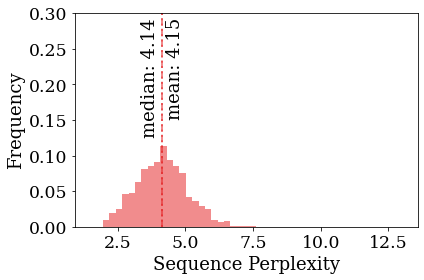

In [25]:
seq_perpl = jnp.exp(losses.mean(axis=(1, 2)))
eval.plot_perplexity_hist(
    seq_perpl,
    min_max=(1.5, 13),
    ylim=(0, 0.3),
    nbins=50
)
plt.savefig(f'../figures/seq_perpl_{stock}.png', dpi=300)

In [44]:
# perplexity per token position --> table
jnp.exp(losses.mean(axis=(0, 1)))

Array([  2.1452491,   1.7127261,   1.0353924,   5.552852 ,   3.1834166,
         1.0019593,   6.214735 , 405.48682  , 770.00806  ,   1.0363657,
         1.4469483,   1.0705057,   1.0073589,   1.625998 ,   2.4061372,
         2.0936184,   1.9338197], dtype=float32)

In [45]:
with onp.printoptions(precision=2, suppress=True):
    print(jnp.exp(losses.mean(axis=(0, 1))))

[  2.15   1.71   1.04   5.55   3.18   1.     6.21 405.49 770.01   1.04
   1.45   1.07   1.01   1.63   2.41   2.09   1.93]


In [46]:
losses.mean()

Array(1.290113, dtype=float32)

In [48]:
# calculate perplexity standard error
eval.calc_bootstrapped_ci(losses.reshape(-1), lambda x: jnp.exp(jnp.mean(x)), rng, ci=0.95, n_bootsrap=100)

(Array(0.00429482, dtype=float32), Array([3.626159, 3.641524], dtype=float32))

In [49]:
jnp.exp(losses.mean())

Array(3.633197, dtype=float32)

[[0.35251    0.5249197  0.09158999]
 [0.3723705  0.5504002  0.10856   ]]


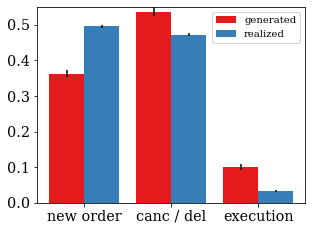

In [29]:
rng, rng_ = jax.random.split(rng)

eval.plot_order_type_frequency(
    results['event_types_gen'],
    results['event_types_eval'],
    rng_,
    combine_mod = True
)
# set y axis limit
plt.ylim(0, 0.55)
plt.savefig(f'../figures/event_types_{stock}.png', dpi=300)

In [59]:
min_x = min(results['delta_t_gen'].min(), results['delta_t_eval'].min())
max_x = max(results['delta_t_gen'].max(), results['delta_t_eval'].max())
min_x, max_x
# GOOG: (Array(1.e-09, dtype=float32), Array(875.4253, dtype=float32))
# INTC: 

(Array(1.e-09, dtype=float32), Array(875.4253, dtype=float32))

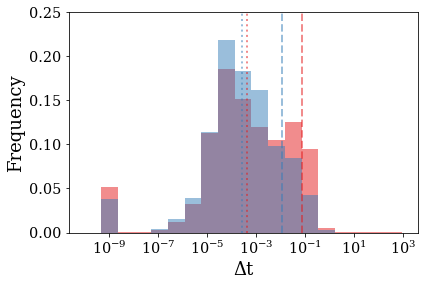

In [61]:
_ = eval.plot_log_hist(results['delta_t_gen'].flatten(), add_text=False, min_max=(1.e-10, 875.4253))
_ = eval.plot_log_hist(results['delta_t_eval'].flatten(), add_text=False, min_max=(1.e-10, 875.4253))
# set y axis limit
plt.ylim(0, 0.25)
plt.savefig(f'../figures/time_hist_{stock}.png', dpi=300)

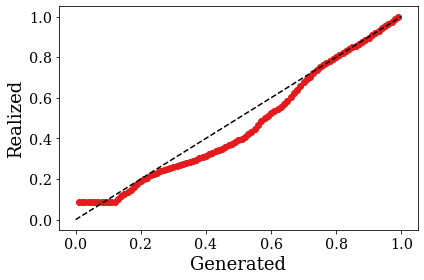

In [284]:
eval.prob_plot_2samples(
    results['delta_t_gen'].flatten(),
    results['delta_t_eval'].flatten()
)
plt.savefig(f'../figures/time_prob_{stock}.png', dpi=300)

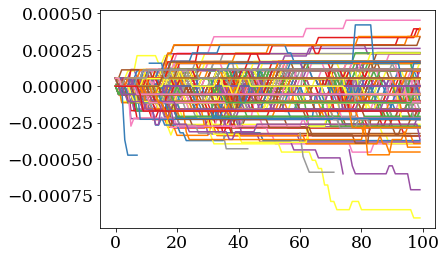

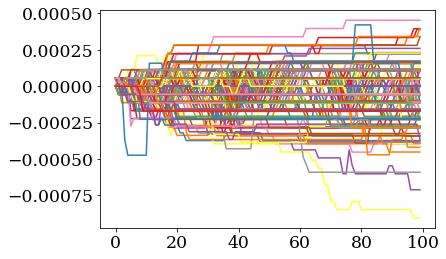

In [51]:
# remove NaNs (temporary empty book side) by forward filling returns

r_gen_df = pd.DataFrame(results['rets_gen'].T)

r_gen_df.plot()
# remove legend from current axis
plt.gca().get_legend().remove()

r_gen_df = r_gen_df.fillna(method='ffill')
r_gen_df.plot()
plt.gca().get_legend().remove()

r_gen = jnp.array(r_gen_df.values).T
r_eval = pd.DataFrame(results['rets_eval'].T).fillna(method='ffill')
r_eval = jnp.array(r_eval.values).T

# remove series starting with NaNs (one empty book side)
r_gen = r_gen[~jnp.isnan(r_eval[:, 0])]  # ... where eval is NaN!
r_eval = r_eval[~jnp.isnan(r_eval[:, 0])]

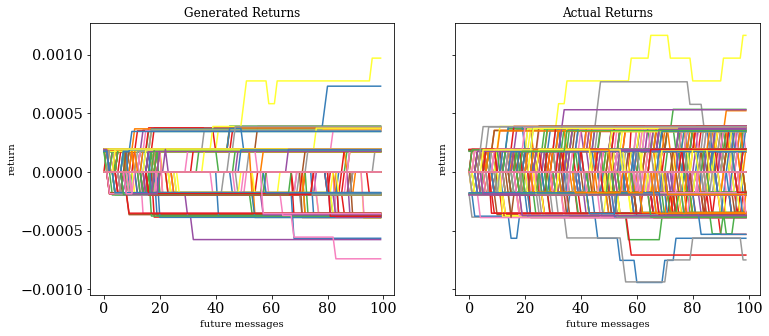

In [286]:
eval.plot_returns(r_gen, r_eval)

In [287]:
results['rets_gen'].shape

(989, 100)

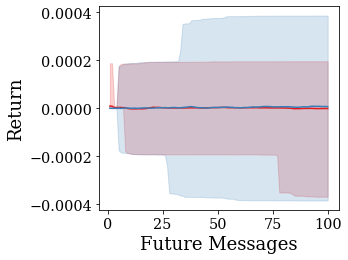

In [288]:
eval.plot_mean_returns(r_gen.T, r_eval.T)
plt.savefig(f'../figures/ret_dist_{stock}.png', dpi=300)

In [73]:
se, percentiles = eval.calc_moments_se(results['rets_gen'], rng)

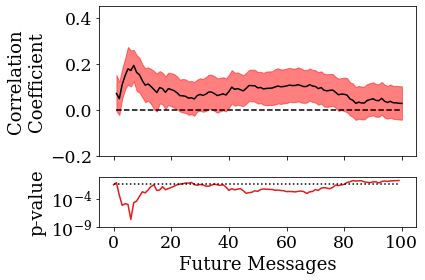

In [52]:
rng, rng_ = jax.random.split(rng)
eval.plot_ret_corr(
    r_gen,
    r_eval,
    ci=0.95,
    ylims=((-0.2, 0.45), (1e-9, 1)),
    rng=rng_
)
plt.savefig(f'../figures/corr_{stock}.png', dpi=300)

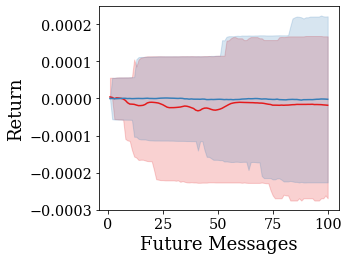

In [240]:
eval.plot_mean_returns(r_gen.T, r_eval.T)

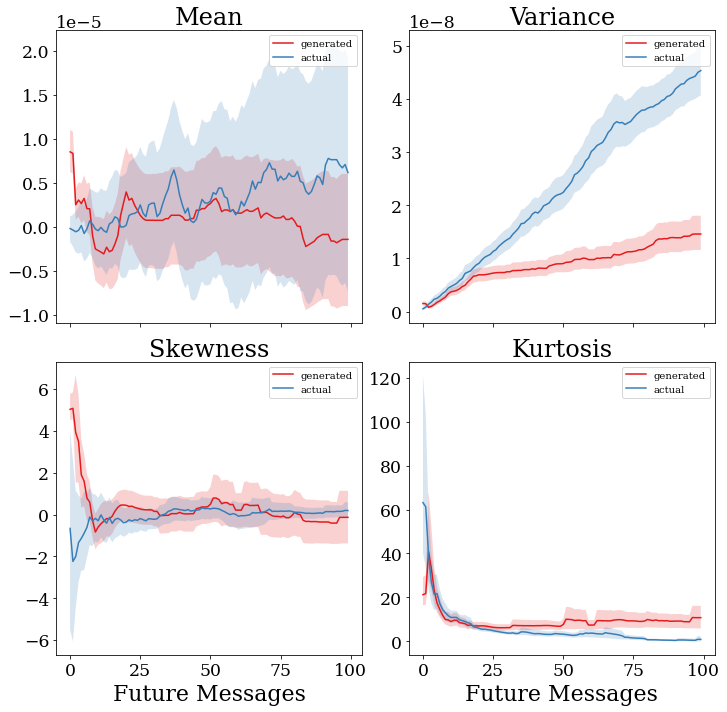

In [290]:
eval.plot_moments(r_gen, r_eval, ci=0.95, rng=rng_)
plt.savefig(f'../figures/moments_{stock}.png', dpi=300)